# Milestone 2 - Adavengers 2023

In this milestone, we will get acquainted with the data, preprocess it and do necessary descriptive statistics tasks. We will also plan our future analysis in detail and describe, as well as test, proposed methodologies.

In [5]:
#This can be deleted later:
#Idea for structure of this Milestone 2 Notebook:
#Step 1: Importing Data
#Step 2: Cleaning Data - remove Nans, PAY ATTENTION TO DUPLICATES!
#Step 3: Descriptive Statistics - how is data distributed, what are mean values,... 
#Step 4: Getting into details of adjectives topic (if we get that far): 
    #test how we can identify adjectives 
    #and who if a sentence is about male or female
#Step 5: maybe start answering our other research questions, if we have time!

In [6]:
#QUESTIONS general:
#should we merge everything to one df? probably, right?

In [7]:
#Library Imports
import pandas as pd
import numpy as np
from statsmodels.stats import diagnostic

## Step 1: Importing the Data

In [8]:
metadata_headers = ["Wikipedia movie ID", "Freebase movie ID", "Movie name" , "Movie release date", "Movie box office revenue", "Movie runtime", "Movie languages","Movie countries", "Movie genres"]
dfmetadata = pd.read_csv('data/movie.metadata.tsv',sep='\t',header =None, names =metadata_headers)
#dfmetadata.head()

#Reading in the Data
dfsummaries=pd.read_table('data/plot_summaries.txt',header=None,names=["Wikipedia movie ID","Summary Text"])
#pd.set_option('display.max_colwidth', None)
#dfsummaries.head()

## Step 2 A: Cleaning Summaries Data

In [9]:
#Checking if the Wikipedia Movie IDs in summaries are the same as in Metadata by randomly checking an id (31186339)
print(dfsummaries[dfsummaries["Wikipedia movie ID"]==31186339]["Summary Text"])
print(dfmetadata[dfmetadata["Wikipedia movie ID"]==31186339]["Movie name"])
#Yes, both these entries correspond to the hunger games.

1    The nation of Panem consists of a wealthy Capi...
Name: Summary Text, dtype: object
78373    The Hunger Games
Name: Movie name, dtype: object


In [10]:
#Checking if there are NaNs
print(dfsummaries["Wikipedia movie ID"].hasnans) #There are no NaNs.
print(dfsummaries["Summary Text"].hasnans) #There are no NaNs.

False
False


In [11]:
#Checking if there are double entries and removing them
print(dfsummaries["Wikipedia movie ID"].is_unique) #This is true, nice!
print(dfsummaries["Summary Text"].is_unique) #This is false
dfsummaries.drop_duplicates(['Summary Text'],inplace=True)
print(dfsummaries["Summary Text"].is_unique) 
#Now we can see there are no more duplicates (remember to do same for metadata!)

True
False
True


In [12]:
#Another thing we could do is look at the type of the data. 
#The IDs should all be positive integers, the summaries all str.
dfsummaries.dtypes #We can see that this is the case

Wikipedia movie ID     int64
Summary Text          object
dtype: object

In [13]:
#Checking if we have negative values for ID
dfsummaries["Wikipedia movie ID"].min() #Nice! They're all positive.

330

## Step 2 B Describing Summaries Data

In [14]:
#Checking how many entries there are
print("number of summary entries:",len(dfsummaries))
print("number of metadata entries:",len(dfmetadata)) 
#We can see that there is not a summary for every movie but only about half.

number of summary entries: 42295
number of metadata entries: 81741


In [15]:
#Check the lengths of the summaries (we can see that there is a great spread.)
dfsummaries["Summary Length"]=dfsummaries['Summary Text'].apply(lambda x: len(x))
print("The length of summaries ranges from %d to %d characters." %(dfsummaries["Summary Length"].min(),dfsummaries["Summary Length"].max()))

The length of summaries ranges from 99 to 28159 characters.


<Axes: >

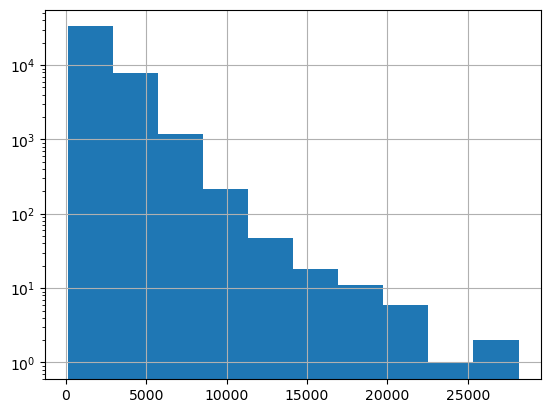

In [16]:
#Displayed in a logarithmic histogram, we can see that most movie summaries are short and a few are bigger.
dfsummaries["Summary Length"].hist(log=True)

In [17]:
#So, how are the summary lengths actually distributed? Let's find out
print(diagnostic.kstest_normal(dfsummaries['Summary Length'].values, dist = 'norm'))
print(diagnostic.kstest_normal(dfsummaries['Summary Length'].values, dist = 'exp'))
#P-avlue < 0.05. The summary lengths are neither normal nor exponentially dist

(0.17600313678761495, 0.0009999999999998899)
(0.057159497591442864, 0.0009999999999998899)


## Step 3A Cleaning Metadata

In [18]:
dfmetadata.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [19]:
dfmetadata.dtypes

Wikipedia movie ID            int64
Freebase movie ID            object
Movie name                   object
Movie release date           object
Movie box office revenue    float64
Movie runtime               float64
Movie languages              object
Movie countries              object
Movie genres                 object
dtype: object

In [96]:
dfmetadata.info() 
#We can see that there are some NaNs for the release date and the runtime. 
#Especially, there seem to be alot of NaNs for box office revenue!
#This is important as it might affect the feasibility of answering the question if the amount of women in a movie
#has an effect on box office revenue. Luckily, this is not the main focus of our project.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Wikipedia movie ID        81741 non-null  int64  
 1   Freebase movie ID         81741 non-null  object 
 2   Movie name                81741 non-null  object 
 3   Movie release date        74839 non-null  object 
 4   Movie box office revenue  8401 non-null   float64
 5   Movie runtime             61291 non-null  float64
 6   Movie languages           81741 non-null  object 
 7   Movie countries           81741 non-null  object 
 8   Movie genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [107]:
(len(dfmetadata)-dfmetadata["Movie box office revenue"].isna().sum()) /len(dfmetadata)
#We can see that we only have box office revenue values for around 10% of the movie data!

0.1027758407653442